# 库

In [2]:
openslide_path = {'desktop':'D:/edge下载/openslide-win64-20220811/bin',
                'laptop':'E:/openslide-win64-20171122/bin'}
package_list = [
    '/home/wangyh/uro_biomarker/stain-normalizer/'
]
import os
from pathlib import Path
if hasattr(os,'add_dll_directory'):
    for i in openslide_path.values():
        if Path(i).exists():
            with os.add_dll_directory(Path(i)):
                import openslide
else:
    import openslide
from openslide.deepzoom import DeepZoomGenerator
import numpy as np
#import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import cv2
import skimage
from lxml import etree
from matplotlib import pyplot as plt

from pathlib import Path
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import gc
import time
import sys
import getopt
import pandas as pd
import glob
import tifffile as tif
import staintools
for i in package_list:
    sys.path.append(i)
# import StainNormalizer
# from StainNormalizer import Normalizer
import cupy as cp #用与cuda相符的版本
from tqdm import tqdm

In [3]:
import torch
from torchvision import transforms
import torchstain

/home/wangyh/miniconda3/envs/patho_AI/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 函数

## 基本函数

In [4]:
def draw(training,validation,test,fold,labels,threshold=1000000,
            absolute=False,remove_large_data_on=False,print_result = False):

    def remove_large_data():
        nonlocal training, validation, test, fold, labels,threshold
        sum = training + validation + test
        index = np.where(sum > threshold)
        training = np.delete(training, index)
        validation = np.delete(validation, index)
        test = np.delete(test, index)
        labels_copy = labels
        labels = [labels_copy[x] for x in range(len(labels_copy)) if x not in np.array(index).tolist()[0]] # index：(array([3, 5, 6], dtype=int64),)，一个tuple，不能够用in直接判断，转成ndarray后再转成list以用in判断之
        print('enter remove_large_data')
        return training,validation,test,labels
        
    plt.figure(figsize=(20,10))
    plt.title('dataset split')

    if not absolute:
        plt.yticks(np.linspace(0,1,11),labels=np.arange(0,101,10).tolist())
        plt.ylabel('percentage')
        sum = training+validation+test
        bottom = training/sum
        center = validation/sum
        top = test/sum
    else:
        if remove_large_data_on:
            bottom,center,top,labels = remove_large_data()
        else:
            bottom = training
            center = validation
            top = test
        plt.yticks(np.linspace(0,np.max(bottom+center+top),10))
        plt.ylabel('absolute amount')

    N = bottom.size
    ind = np.arange(N)
    plt.xticks(np.arange(N),labels=labels,rotation=45)

    width = 0.35  # 设置条形图一个长条的宽度
    p1color = ['dodgerblue' if x else 'royalblue' for x in fold]
    p2color = ['chartreuse' if x else 'limegreen'for x in fold]
    p3color = ['gold' if x else 'orangered' for x in fold]
    if print_result:
        print(bottom,center,top,sum,p1color)
    else:


        p1 = plt.bar(ind, bottom, width, color=p1color)  
        p2 = plt.bar(ind, center, width, bottom=bottom,color=p2color)  #在p1的基础上绘制，底部数据就是p1的数据
        p3 = plt.bar(ind, top, width, bottom=bottom+center,color=p3color)    #在p1和p2的基础上绘制，底部数据就是p1和p2

        plt.legend((p1[1], p2[1], p3[1]), ('training', 'validation', 'test'),loc = 3)

        plt.show()

class Timer():
    def __init__(self,proc):
        self._begin_time = None
        self.proc = proc

    def tic(self):
        print(f'{self.proc} start!')
        self._begin_time = time.perf_counter()

    def toc(self):
        print(f'{self.proc} finish!,consuming {time.perf_counter() - self._begin_time}')
        return time.perf_counter() - self._begin_time

def binary_conversion(var):
    """
    二进制单位转换
    :param var: 需要计算的变量，bytes值
    :return: 单位转换后的变量，kb 或 mb
    """
    var_size = sys.getsizeof(var)
    assert isinstance(var_size, int)
    if var_size <= 1024:
        return f'占用 {round(var_size / 1024, 2)} KB内存'
    else:
        return f'占用 {round(var_size / (1024 ** 2), 2)} MB内存'
    
def show_info(show_OI = False,show_values = False,**kws):
    length = 'no length'
    keys = 'not a dict'
    values = 'not a dict'
    shape = 'not a ndarray'
    size = 'not a ndarray'
    for key,x in kws.items():
        if hasattr(x,'__len__'):
            length = len(x)
        if isinstance(x,dict):
            keys = x.keys()
            values = x.values()
        if type(x) is np.ndarray or type(x) is cp.ndarray or type(x) is torch.Tensor:
            shape = x.shape
            size = x.size
        print(key)
        print(f'allocated memory:{binary_conversion(x)}')
        print(f'\ntype:{type(x)} \nlen:{length}\nshape:{shape}\nsize:{size}\nkeys:{keys}\n')
        if show_OI:
            print(f'original info:{x}\n')
        if show_values:
            print(f'\nvalues:{values}\n')

## 图片可视化

In [5]:
def null_or_not(x,pr = False):  #只要有一个元素不为0则不为0
    if type(x) is not np.ndarray:
        x = np.array(x)
    if pr:
        if x.any():
            print('not all 0')
        else:
            print('all 0')
    return x.any()

def show_dzg_info(dzg):
    print(f'level count:{dzg.level_count}')
    print(f'tile arrangement of last 3 level{dzg.level_tiles[-4:-1]}\ndimensions of each tile at last 3 level:{dzg.level_dimensions[-4:-1]}')

def pop_tile(dzg,level,save = False):
    row,col = dzg.level_tiles[level]
    saved = []
    if level<0:
        level = dzg.level_count + level
    for i in range(row):
        for j in range(col):
            if null_or_not(dzg.get_tile(level,(i,j))):
                saved.append((i,j))
                if not save:
                    print((i,j))
    if save:
        return saved

def pixel_255(image,point = False,threshold = False):
    if type(image) is not np.ndarray:
        image = np.array(image)
        if point:
            image[image==0] = 255
        if threshold:
            image[image>threshold] = 255 
        return Image.fromarray(image)
    else:
        if point:
            image[image==0] = 255
        if threshold:
            image[image>threshold] = 255 
        return image

#通过cv显示图片
def imgshow(img_path):
    tiff = cv2.imread(img_path)
    plt.imshow(Image.fromarray(tiff))

#查看tiff文件path、info及图片
def tiff_checker(tiff_path):
    show_info(tiff_path = tiff_path)
    tif.imshow(tif.imread(tiff_path))

#同时展示多张图片
def ploting(rows,cols,figseq,
            figsize=(20,20),fontdict={'size':20},title = []):
    #figseq是一个4维的ndarray
    #rows,cols是展示图片的行/列数
    fig,axes = plt.subplots(rows,cols,figsize=figsize)
    fontdict = fontdict
    if rows != 1:
        for i in range(rows):
            for j in range(cols):
                if title:
                    axes[i,j].set_title(title[i*cols+j])
                else:
                    axes[i,j].set_title(f'{i}_{j}')
                axes[i,j].imshow(figseq[i*cols+j])
    else:
        for j in range(cols):
            if title:
                axes[j].set_title(title[j])
            else:
                axes[j].set_title(f'{j}')
            axes[j].imshow(figseq[j])

## stainnormalizer

In [6]:
#切割的图片大小大多为512，normalization将非512*512的去除，大约占比为10%
def gen_normal_size(I_list,target_shape=(512,512,3)):
    for i in I_list:
        try:
            tiff = tif.imread(i)
            if tiff.shape == target_shape:
                yield i
        except Exception as e:
            print(e)
            pass

#normalizer类
class HENormalizer:
    def fit(self, target):
        pass

    def normalize(self, I, **kwargs):
        raise Exception('Abstract method')

"""
Inspired by torchstain :
Source code adapted from: https://github.com/schaugf/HEnorm_python;
Original implementation: https://github.com/mitkovetta/staining-normalization
"""
class Normalizer(HENormalizer):
    def __init__(self):
        super().__init__()

        self.HERef = cp.array([[0.5626, 0.2159],
                          [0.7201, 0.8012],
                          [0.4062, 0.5581]])
        self.maxCRef = cp.array([1.9705, 1.0308])

    def __convert_rgb2od(self, I, Io=240, beta=0.15):
        # calculate optical density
        OD = -cp.log((I.astype(cp.float32)+1)/Io)

        # remove transparent pixels
        ODhat = OD[~cp.any(OD < beta, axis=1)]

        return OD, ODhat

    def __find_HE(self, ODhat, eigvecs, alpha):
        #project on the plane spanned by the eigenvectors corresponding to the two
        # largest eigenvalues
        That = ODhat.dot(eigvecs[:,1:3])

        phi = cp.arctan2(That[:,1],That[:,0])

        minPhi = cp.percentile(phi, alpha)
        maxPhi = cp.percentile(phi, 100-alpha)

        vMin = eigvecs[:,1:3].dot(cp.array([(cp.cos(minPhi), cp.sin(minPhi))]).T)
        vMax = eigvecs[:,1:3].dot(cp.array([(cp.cos(maxPhi), cp.sin(maxPhi))]).T)

        # a heuristic to make the vector corresponding to hematoxylin first and the
        # one corresponding to eosin second
        if vMin[0] > vMax[0]:
            HE = cp.array((vMin[:,0], vMax[:,0])).T
        else:
            HE = cp.array((vMax[:,0], vMin[:,0])).T

        return HE

    def __find_concentration(self, OD, HE):
        # rows correspond to channels (RGB), columns to OD values
        Y = cp.reshape(OD, (-1, 3)).T

        # determine concentrations of the individual stains
        C = cp.linalg.lstsq(HE, Y, rcond=None)[0]

        return C

    def __compute_matrices(self, I, Io, alpha, beta):
        I = I.reshape((-1,3))

        OD, ODhat = self.__convert_rgb2od(I, Io=Io, beta=beta)
        assert len(ODhat)!=0,'all pixels are transparent'
        # compute eigenvectors
        _, eigvecs = cp.linalg.eigh(cp.cov(ODhat.T))

        HE = self.__find_HE(ODhat, eigvecs, alpha)

        C = self.__find_concentration(OD, HE)

        # normalize stain concentrations
        maxC = cp.array([cp.percentile(C[0,:], 99), cp.percentile(C[1,:],99)])

        return HE, C, maxC

    def fit(self, I, Io=240, alpha=1, beta=0.15):
        I = cp.asarray(I)
        HE, _, maxC = self.__compute_matrices(I, Io, alpha, beta)

        self.HERef = HE
        self.maxCRef = maxC
        return self.HERef,self.maxCRef

    def normalize(self, I, Io=240, alpha=1, beta=0.15):
        ''' Normalize staining appearence of H&E stained images
        Example use:
            see test.py
        Input:
            I: RGB input image
            Io: (optional) transmitted light intensity
        Output:
            Inorm: normalized image
            H: hematoxylin image
            E: eosin image
        Reference:
            A method for normalizing histology slides for quantitative analysis. M.
            Macenko et al., ISBI 2009
        '''
       # I = cp.asarray(I)
        batch,h, w, c = I.shape
        I = I.reshape((-1,3))

        HE, C, maxC = self.__compute_matrices(I, Io, alpha, beta)

        maxC = cp.divide(maxC, self.maxCRef)
        C2 = cp.divide(C, maxC[:, cp.newaxis])

        # recreate the image using reference mixing matrix
        Inorm = cp.multiply(Io, cp.exp(-self.HERef.dot(C2)))
        Inorm[Inorm > 255] = 255
        Inorm = cp.reshape(Inorm.T, (batch,h, w, c)).astype(cp.uint8)



        return Inorm


In [7]:
template_paths = [i for i in gen_normal_size(glob.glob('/mnt/wangyh/TCGA_patches/H/c7bcb827-9da0-4b07-8065-3ce01befec13/40X/*.tiff'))]
template_file = pixel_255(tif.TiffSequence(template_paths[:100]).asarray(),point=True)

SN_normalizer = Normalizer()
HEref,maxCRef = SN_normalizer.fit(template_file[11])

### 循源代码debug

In [8]:
def pub__convert_rgb2od(I, Io=240, beta=0.15):
    # calculate optical density
    OD = -cp.log((I.astype(cp.float32)+1)/Io)

    # remove transparent pixels
    ODhat = OD[~cp.any(OD < beta, axis=1)]

    return OD, ODhat

def pub__find_concentration(self, OD, HE):
    # rows correspond to channels (RGB), columns to OD values
    Y = cp.reshape(OD, (-1, 3)).T

    # determine concentrations of the individual stains
    C = cp.linalg.lstsq(HE, Y, rcond=None)[0]

    return C

def pub__find_HE(self, ODhat, eigvecs, alpha = 1):
    #project on the plane spanned by the eigenvectors corresponding to the two
    # largest eigenvalues
    That = ODhat.dot(eigvecs[:,1:3])

    phi = cp.arctan2(That[:,1],That[:,0])

    minPhi = cp.percentile(phi, alpha)
    maxPhi = cp.percentile(phi, 100-alpha)

    vMin = eigvecs[:,1:3].dot(cp.array([(cp.cos(minPhi), cp.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(cp.array([(cp.cos(maxPhi), cp.sin(maxPhi))]).T)

    # a heuristic to make the vector corresponding to hematoxylin first and the
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = cp.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = cp.array((vMax[:,0], vMin[:,0])).T

    return HE
    
def pub__compute_matrices(I, Io, alpha, beta):
    I = I.reshape((-1,3))

    OD, ODhat = pub__convert_rgb2od(I, Io=Io, beta=beta)
    print(f'OD={OD}\n\nODhat={ODhat}\n')
    # compute eigenvectors
    _, eigvecs = cp.linalg.eigh(cp.cov(ODhat.T))
    print(f'_={_}\n\neigvec={eigvecs}')

#     HE = pub__find_HE(ODhat, eigvecs, alpha)

#     C = pub__find_concentration(OD, HE)

#     # normalize stain concentrations
#     maxC = cp.array([cp.percentile(C[0,:], 99), cp.percentile(C[1,:],99)])

#     return HE, C, maxC

In [9]:
I = tif.imread('/mnt/wangyh/TCGA_patches/L/1f24af21-9bb4-409f-8bbc-5a0e56d777ab/40X/nonT_222_59.tiff')
I = I.reshape(1,512,512,3)
I = cp.asarray(I,dtype=cp.float64)
batch,h, w, c = I.shape
I = I.reshape((-1,3))
OD,ODhat = pub__convert_rgb2od(I)
# HE, C, maxC = pub__compute_matrices(I,Io=240, alpha=1, beta=0.15)

In [9]:
# show_info(odhat = ODhat)

In [10]:
# tile_img = tif.imread('/mnt/wangyh/TCGA_patches/L/1f24af21-9bb4-409f-8bbc-5a0e56d777ab/40X/nonT_222_59.tiff')  #读取to_transformed tile
# tile_img = tile_img.reshape(1,512,512,3)
# imgs = cp.asarray(tile_img,dtype=cp.float64)
# norm_imgs= cp.asnumpy(SN_normalizer.normalize(I=imgs))
# norm_imgs = norm_imgs.reshape(512,512,3)
# tif.imshow(norm_imgs)

# debug

## 测试程序

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

cases = glob.glob(f"/mnt/wangyh/TCGA_patches/*/*/")
cn_path_test = '/home/wangyh/uro_biomarker/patho_AI/CN_test/'
cases_select = cases[:2]

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

template_paths = [i for i in gen_normal_size(glob.glob('/mnt/wangyh/TCGA_patches/H/c7bcb827-9da0-4b07-8065-3ce01befec13/40X/*.tiff'))]
template_file = pixel_255(tif.TiffSequence(template_paths[:100]).asarray(),point=True)



## 初始化normalizer

In [12]:
'''
use staintools
'''
# # Read data
# target = staintools.read_image(template_paths[27])

# # Standardize brightness (optional, can improve the tissue mask calculation)
# target = staintools.LuminosityStandardizer.standardize(pixel_255(target,point=True))

# # Stain normalize initializatino
# normalizer = staintools.StainNormalizer(method='vahadane')
# normalizer.fit(target)

'''
use stain_normalizer
'''
# template = pixel_255(tif.imread('/mnt/wangyh/TCGA_patches/L/9cf7130c-f381-45df-ae0a-c14017637537/40X/T_189_83.tiff'),point=True)
SN_normalizer = Normalizer()
SN_normalizer.fit(template_file[11])
# target_tile = cp.asarray(target_tiles[:50])
# SN_normed = SN_normalizer.normalize(target_tile)

'''
use torchstain
'''
# template = cv2.cvtColor(cv2.imread(template_paths[11]), cv2.COLOR_BGR2RGB)
# T = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x*255)
# ])

# torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
# torch_normalizer.fit(T(template))

unnorm_tiles = []

print(len(cases_select))


2


### 使用tif.imread读取即可。返回一个RGB的np.array

In [13]:
# template = cv2.cvtColor(cv2.imread(template_paths[11]),cv2.COLOR_RGB2BGR)
# show_info(t = template,tf = template_file[11])
# template == template_file[11]

In [13]:
for case in tqdm(cases_select):
    label = Path(case).parent.name
    tiles = list(Path(case).rglob("*/*"))
    print(len(tiles))
    try:
        for tile in tiles:
            try:
                tile_name = str(tile).replace('/mnt/wangyh/TCGA_patches/',cn_path_test)  #transformed tile的存放路径
                if not Path(tile_name).exists():
                    if not Path(tile_name).parent.exists():
                        Path(tile_name).parent.mkdir(parents=True)
                        
                    tile_img = tif.imread(str(tile))  #读取to_transformed tile
                    if tile_img.shape[0] != 512 or tile_img.shape[1] != 512:
                        tile_img = Image.fromarray(np.uint8(tile_img)).resize((512,512),Image.ANTIALIAS)
                        tile_img = np.asarray(tile_img)
                    #tile_name = str(tile).replace
                   # tile_img = tif.imread(str(tile))
                    #print(tile_img)
                    
                    '''
                    staintools
                    '''
#                     lum_stand_tile = staintools.LuminosityStandardizer.standardize(pixel_255(tile_img,point=True))
#                     norm_imgs = normalizer.transform(lum_stand_tile)
                    
                    '''
                    stain_normalizer
                    '''
                    tile_img = tile_img.reshape(1,512,512,3)
                    imgs = cp.asarray(tile_img,dtype=cp.float64)
                    norm_imgs= cp.asnumpy(SN_normalizer.normalize(I=imgs))
                    norm_imgs = norm_imgs.reshape(512,512,3)
                    
                    '''
                    torchstain
                    '''
#                     t_tile_img = T(tile_img)
#                     norm_imgs,_H,_E = torch_normalizer.normalize(I = t_tile_img,stains = True)
                
                    tif.imsave(tile_name,norm_imgs)
                   # Image.fromarray(np.uint8(norm_imgs)).save(tile_name)
            except Exception as e:
                    print(e)
                    print(tile)
                    unnorm_tiles.append(tile)
            #norm_imgs = None
            imgs = None
            mempool.free_all_blocks() 
            pinned_mempool.free_all_blocks()
            gc.collect() 
     
    except Exception as e:
        print(e)
        print(case) 
        continue
print('done')
np.save(f"{cn_path_test}unnormed.npy",np.asarray(unnorm_tiles))

  0%|          | 0/2 [00:00<?, ?it/s]

10578


  0%|          | 0/2 [01:41<?, ?it/s]


KeyboardInterrupt: 

## 错误1：触发内存错误

### 在测试时引起崩溃的文件：

/mnt/wangyh/TCGA_patches/L/1f24af21-9bb4-409f-8bbc-5a0e56d777ab/40X/nonT_222_59.tiff

/mnt/wangyh/TCGA_patches/L/8805e6a4-3c48-4f9d-ad45-442891b79908/40X/nonT_4_105.tiff

/mnt/wangyh/TCGA_patches/L/95cbd3e7-5d6a-428a-a2de-1c20b56896f6/40X/nonT_68_8.tiff

/mnt/wangyh/TCGA_patches/H/4311c81b-9c1e-4d86-934d-cdc003444da7/40X/nonT_91_54.tiff

### 诱发错误的步骤：

cp.asarray()

### 报错内容：

cudaErrorIllegalAddress: an illegal memory access was encountered

### 查看图片信息是否有异常

In [6]:
# pic_1 = tif.imread('/mnt/wangyh/TCGA_patches/L/1f24af21-9bb4-409f-8bbc-5a0e56d777ab/40X/nonT_222_59.tiff')
# pic_2 = tif.imread('/mnt/wangyh/TCGA_patches/L/8805e6a4-3c48-4f9d-ad45-442891b79908/40X/nonT_4_105.tiff')
# pic_3 = tif.imread('/mnt/wangyh/TCGA_patches/L/95cbd3e7-5d6a-428a-a2de-1c20b56896f6/40X/nonT_68_8.tiff')
# pic_4 = tif.imread('/mnt/wangyh/TCGA_patches/H/4311c81b-9c1e-4d86-934d-cdc003444da7/40X/nonT_91_54.tiff')

In [11]:
# show_info(
#     _1 = pic_1,
#     _2 = pic_2,
#     _3 = pic_3,
#     _4 = pic_4,show_OI =False)

### 单独进行cp.asarray又不再报错？

In [12]:
# show_info(c = cp.asarray(pic_3))

In [14]:
pic = tif.imread('/mnt/wangyh/CN_patches/H/a29135be-c1a9-4402-b7a5-47cc8172a5ad/10X/T_42_29.tiff')

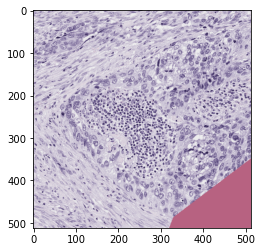

In [15]:
plt.imshow(pic)

## 错误2：cannot reshape into... 

3/4_CN.out

示例图片：

/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/40X/nonT_139_161.tiff

/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/20X/nonT_68_80.tiff

/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/10X/nonT_34_40.tiff

/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/5X/nonT_17_20.tiff

In [13]:
# Rpic_1 = tif.imread('/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/40X/nonT_139_161.tiff')
# Rpic_2 = tif.imread('/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/20X/nonT_68_80.tiff')
# Rpic_3 = tif.imread('/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/10X/nonT_34_40.tiff')
# Rpic_4 = tif.imread('/mnt/wangyh/TCGA_patches/L/bd498605-3c8a-48cf-a47f-ec98b4c606d7/5X/nonT_17_20.tiff')

In [14]:
# show_info(
#     _1 = Rpic_1,
#     _2 = Rpic_2,
#     _3 = Rpic_3,
#     _4 = Rpic_4,show_OI =False)

### 可以被resize解决

#### 测试不同Image方法的异同，肉眼无法发现差异

In [15]:
# tile_img_anti = Image.fromarray(np.uint8(Rpic_1)).resize((512,512),Image.ANTIALIAS)
# tile_img_anti = np.asarray(tile_img_anti)

# tile_img_N = Image.fromarray(np.uint8(Rpic_1)).resize((512,512),Image.NEAREST)
# tile_img_N = np.asarray(tile_img_N)

# tile_img_bil = Image.fromarray(np.uint8(Rpic_1)).resize((512,512),Image.BILINEAR)
# tile_img_bil = np.asarray(tile_img_bil)

# tile_img_bic = Image.fromarray(np.uint8(Rpic_1)).resize((512,512),Image.BICUBIC)
# tile_img_bic = np.asarray(tile_img_bic)

# ploting(1,5,figseq = [Rpic_1,tile_img_anti,tile_img_N,tile_img_bil,tile_img_bic],title = ['original','antialias','nearest','bilinear','bicubic'])

# 解决问题

## 换成torchstain

In [16]:
template = cv2.cvtColor(cv2.imread(template_paths[11]), cv2.COLOR_BGR2RGB)
target_1 = cv2.cvtColor(cv2.imread("/mnt/wangyh/TCGA_patches/L/1f24af21-9bb4-409f-8bbc-5a0e56d777ab/40X/nonT_222_59.tiff"), cv2.COLOR_BGR2RGB) #报错文件
target_2 = cv2.cvtColor(cv2.imread("/mnt/wangyh/TCGA_patches/L/1f24af21-9bb4-409f-8bbc-5a0e56d777ab/40X/nonT_192_57.tiff"), cv2.COLOR_BGR2RGB)

In [17]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
torch_normalizer.fit(T(template))

t_to_transform_2 = T(target_2)
norm_1, H_1, E_1 = torch_normalizer.normalize(I=t_to_transform_2, stains=True)

In [18]:
t_to_transform_1 = T(target_1)
norm, H, E = torch_normalizer.normalize(I=t_to_transform_1, stains=True)

IndexError: kthvalue(): Expected reduction dim 0 to have non-zero size.

In [ ]:
ploting(1,4,figseq=[target_2,norm_1,H_1,E_1],title=['target','norm','H','E'])

In [21]:
show_info(t1 = target_1,t2 = target_2)

t1
allocated memory:占用 0.75 MB内存

type:<class 'numpy.ndarray'> 
len:512
shape:(512, 512, 3)
size:786432
keys:not a dict

original info:[[[165 192 236]
  [164 191 235]
  [164 191 234]
  ...
  [108 148 217]
  [108 148 216]
  [108 148 216]]

 [[165 192 236]
  [164 191 235]
  [164 191 234]
  ...
  [108 148 217]
  [108 148 216]
  [108 148 216]]

 [[165 192 236]
  [164 191 235]
  [164 191 234]
  ...
  [108 148 217]
  [108 148 216]
  [108 148 216]]

 ...

 [[223 229 241]
  [223 229 240]
  [223 229 239]
  ...
  [128 165 223]
  [128 165 223]
  [128 165 223]]

 [[223 229 240]
  [223 229 239]
  [223 229 238]
  ...
  [128 165 223]
  [128 165 223]
  [128 165 223]]

 [[223 229 239]
  [223 229 239]
  [223 229 238]
  ...
  [128 165 223]
  [128 165 223]
  [128 165 223]]]

t2
allocated memory:占用 0.75 MB内存

type:<class 'numpy.ndarray'> 
len:512
shape:(512, 512, 3)
size:786432
keys:not a dict

original info:[[[212 128 156]
  [233 141 164]
  [245 150 177]
  ...
  [245 166 196]
  [235 157 182]
  [225 152 17

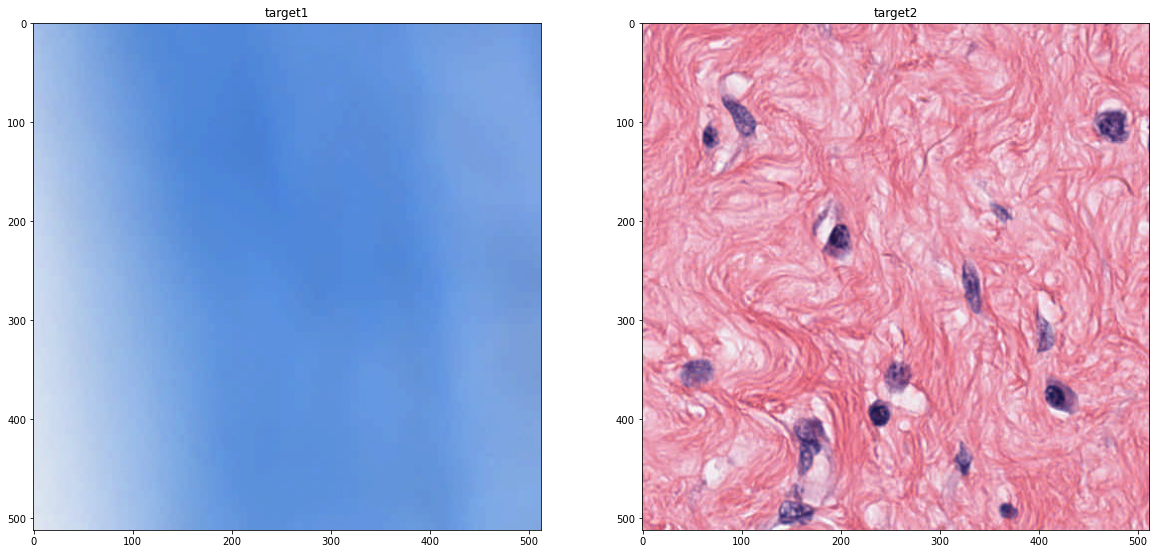

In [22]:
ploting(1,2,figseq = [target_1,target_2],title = ['target1','target2'])